# Review Analysis

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

f:\LangGraph-Learning\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
load_dotenv()

True

In [3]:
import os
model = ChatOpenAI(api_key=os.getenv("OPENROUTER_API_KEY"), 
                   base_url="https://openrouter.ai/api/v1", 
                   model="openai/gpt-oss-120b:free")

In [4]:
#defining the schema

class SentimentSchema(BaseModel):

    sentiment: Literal["positive", "negative"]= Field(description= 'Sentiment of the review')
    

In [5]:
structured_model =model.with_structured_output(SentimentSchema)

In [6]:
prompt ="Return only a JSON object with the field 'sentiment' as either 'positive' or 'negative'. \
Review: 'The product was great and met all my expectations'"

structured_model.invoke(prompt).sentiment

'positive'

In [7]:
class ReviewState(TypedDict):

    review: str
    sentiment : Literal["positive", "negative"]
    diagnosis : dict
    response : str
    

In [8]:
def find_sentiment(state: ReviewState)->ReviewState:

    prompt = f"For the following review find out teh sentiment as either 'positive' or 'negative' and strictly return in JSON format.\n {state['review'] }"

    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}

In [9]:
def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:

    if state['sentiment']== 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'


In [10]:
def positive_response(state: ReviewState) -> ReviewState:

    prompt = f""" Write a warm thank you message in response to this review: \n\n " {state['review']}" 
    Also, kindly ask teh user to leave feedback on our website"""

    response = model.invoke(prompt).content
    return {'response': response}

In [11]:
class DiagnosisSchema(BaseModel):
    # issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description="Type of issue identified in the review")
    # tone: Literal["Angry", "Frustrated", "Disappointed", "Neutral", "Other"] = Field(description="Tone of the review")
    # urgency: Literal["Low", "Medium", "High", "Critical"] = Field(description="Urgency level of the issue") 

    issue_type: str = Field(description="Type of issue identified in the review") 
    tone: str = Field(description="Tone of the review") 
    urgency: str = Field(description="Urgency level of the issue")

In [12]:
# Use json_mode to force strict JSON parsing
structured_model2 = model.with_structured_output(DiagnosisSchema, method="json_mode")


In [13]:
def run_diagnosis(state: ReviewState):
    prompt = f"""
    Diagnose the following negative review:

    "{state['review']}"

    Return ONLY a valid JSON object with the fields:
    - issue_type
    - tone 
    - urgency 

    Do not include code fences, explanations, or extra text.
    """

    response = structured_model2.invoke(prompt)
    return {"diagnosis": response.model_dump()}


In [14]:
def negative_response(state: ReviewState) ->ReviewState:

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
    The customer had a '{diagnosis['issue_type']}' issue and their tone is '{diagnosis['tone']}' with an urgency level of '{diagnosis['urgency']}'.
    Write a compassionate and solution-oriented response to address their concerns based on the diagnosis."""

    response = model.invoke(prompt).content

    return {'response': response}

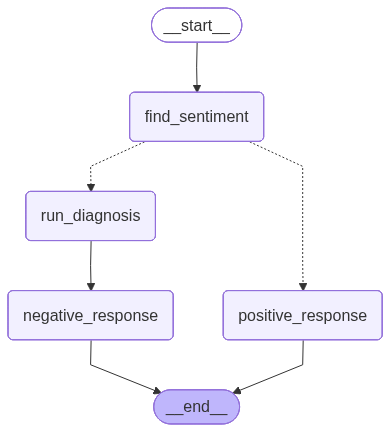

In [15]:
graph= StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('run_diagnosis',run_diagnosis)
graph.add_node('positive_response', positive_response)
graph.add_node('negative_response', negative_response)


graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('negative_response', END)

workflow =graph.compile()
workflow



In [16]:
intial_state = {
    'review' : "The product stopped working after a week of use. I'm very disappointed with the quality and customer service was unhelpful."
}

workflow.invoke(intial_state)

{'review': "The product stopped working after a week of use. I'm very disappointed with the quality and customer service was unhelpful.",
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'product defect',
  'tone': 'frustrated',
  'urgency': 'high'},
 'response': '**Hi\u202f[Customer Name],**\n\nI’m really sorry you’re dealing with a defective product—especially when you needed it to work perfectly. I completely understand how frustrating this is, and I’m treating this as a top‑priority case so we can get it resolved for you right away.\n\n---\n\n### What we’ve found\nAfter reviewing the details you shared (and the diagnostic report from our engineering team), it looks like the issue stems from a **manufacturing fault in the [specific component/model]**. This defect can cause the intermittent failures you’ve experienced, and it’s covered under our warranty.\n\n---\n\n### How we’ll fix it – your options\n\n| Option | What you’ll get | How quickly it’s delivered |\n|--------|------

In [17]:
intial_state = {
    'review' : "I absolutely love this product! It exceeded all my expectations and I will definitely be buying again."
}

workflow.invoke(intial_state)

{'review': 'I absolutely love this product! It exceeded all my expectations and I will definitely be buying again.',
 'sentiment': 'positive',
 'response': 'Thank you so much for your wonderful review! 🌟  \nWe’re thrilled to hear that the product exceeded your expectations and that you’ll be buying again. Your enthusiasm truly makes our day.\n\nIf you have a moment, we’d love for you to share your experience on our website as well. Your feedback helps other shoppers make confident choices and lets us keep delivering the quality you love.\n\nThanks again for your support—looking forward to serving you again soon!'}